# Explicando K-Means Mediante el Algoritmo de Maximización de la Esperanza

<img style="float: right; margin: 0px 0px 15px 15px;" src="https://upload.wikimedia.org/wikipedia/commons/e/e5/KMeans-Gaussian-data.svg" width="500px" height="300px" />

> Ya derivamos la forma general del algoritmo de maximización de la esperanza, e hicimos un ejemplo sencillo. Es hora de ver como se aplica este algoritmo a ejemplos más interesantes.

> Ahora, apliquémoslo para explicar el algoritmo K-Means.

> **Objetivos:**
> - Explicar el algoritmo K-Means usando el algoritmo de maximización de la esperanza.

> **Referencias:**
> - Bayesian Methods for Machine Learning course, HSE University, Coursera.

## 1. Recordando el algoritmo K-Means

**Problema:** dado un conjunto de observaciones $x_1, x_2, \dots, x_N \in \mathbb{R}^d$, se debe particionar las $N$ observaciones en $k$ ($\leq N$) clusters $\{1, 2, \dots, k\}$, de manera que se minimice la suma de distancias al cuadrado (varianza).

In [1]:
# Importamos función para generar datos
from bank_customer_data import generate_bank_customer_data
# Importamos pyplot
from matplotlib import pyplot as plt
# Importamos numpy
import numpy as np

In [2]:
# Generamos datos
data = generate_bank_customer_data()
data.head()

,income,debt,labels
0,4.020895,2.179105,0.0
1,3.800091,1.470849,0.0
2,5.773552,3.688368,2.0
3,0.512974,6.215452,1.0
4,2.498779,3.266450,0.0


Text(0, 0.5, 'Deuda (x100k MXN)')

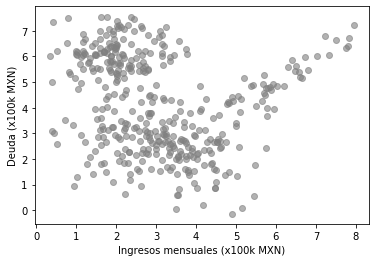

In [3]:
# Datos
plt.scatter(data["income"], data["debt"], c="gray", alpha=0.6)
plt.xlabel("Ingresos mensuales (x100k MXN)")
plt.ylabel("Deuda (x100k MXN)")

Text(0, 0.5, 'Deuda (x100k MXN)')

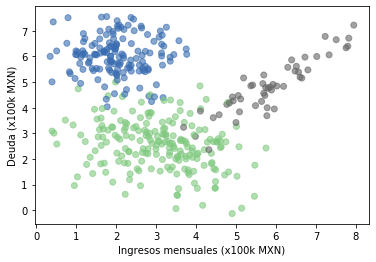

In [4]:
# Grupos "reales"
plt.scatter(data["income"], data["debt"], c=data["labels"], cmap="Accent", alpha=0.6)
plt.xlabel("Ingresos mensuales (x100k MXN)")
plt.ylabel("Deuda (x100k MXN)")

**Algoritmo:**

1. Inicializar los parámetros $\theta = \{\mu_1, \dots, \mu_k\}$ de manera aleatoria.
2. Repetir hasta la convergencia (hasta que los parámetros no varíen):
   1. Para cada punto calcule el centroide más cercano:
      $$
      c_i = \arg \min_{c} ||x_i - \mu_c||.
      $$
      
   2. Actualizar centroides:
      $$
      \mu_c = \frac{\sum_{i: c_i = c} x_i}{\sum_{i: c_i = c} 1}
      $$

## 2. Conexión con algoritmo de maximización de la esperanza

Desde una perspectiva probabilística, modelamos el K-Means como un modelo de variable latente:

![latent](figures/latent_model.png)

En efecto, la idea es similar al modelo de mezclas Gaussianas, fijando:

- $\Sigma_c = I$.
- $\pi_c = \frac{1}{k}$.

Con lo anterior, la distribución:

$$
p(x_i | t_i=c, \theta) = \mathcal{N}(x_i | \mu_c, I) = \frac{1}{\sqrt{(2 \pi)^n}} \exp\left(-\frac{1}{2}||x_i - \mu_c||^2\right)
$$

### E-step

Para cada punto, debemos encontrar la distribución variacional que minimiza:

$$
q^{j+1} = \arg \min_{q \in Q}\sum_{i=1}^{N} \mathcal{KL}(q(t_i) || p(t_i|x_i, \theta^j)).
$$

Sin embargo, recordamos que el K-Means es un esquema de hard clustering, que solo acepta que un punto pertenezca a un único cluster.

Es decir las posibles opciones para $q$ es el conjunto $Q$ de funciones $\delta$:

$$
Q = \left\{f: f(t)=\delta(t - c) \right\},
$$

donde 

$$
\delta(t - c) = \left\lbrace\begin{array}{ccc} 
                1 & \text{si} & t=c\\
                0 & \text{en otro caso}
\end{array}
\right.
$$

In [5]:
def fun_delta(t, c):
    return (t == c) * 1

In [8]:
t = np.linspace(8, 12, 101)
y = fun_delta(t, 10)

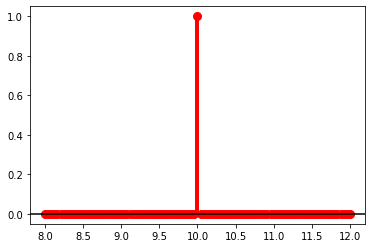

In [9]:
plt.plot(t, y, 'ro', ms=8)
plt.vlines(t, 0, y, colors='r', lw=4)
plt.axhline(y=0, color='k')
plt.show()

**Pregunta:** 

Supongamos que tenemos la siguiente distribución posterior $p(t|x, \theta)$:

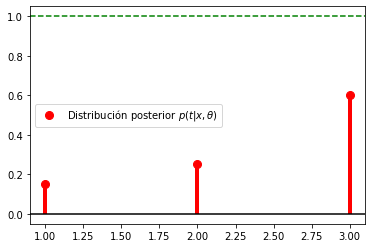

In [10]:
plt.plot([1, 2, 3], [0.15, 0.25, 0.6], 'ro', ms=8, label=r"Distribución posterior $p(t|x, \theta)$")
plt.vlines([1, 2, 3], 0, [0.15, 0.25, 0.6], colors='r', lw=4)
plt.axhline(y=0, color='k')
plt.axhline(y=1, ls='--', color='g')
plt.legend()
plt.show()

¿Cuál será la función tipo $\delta$ que más se acerque a esta distribución (de acuerdo a la divergencia $\mathcal{KL}$)?

Tenemos 3 opciones razonables para $q$:

1. $q=\delta(t - 1)$

   \begin{align}
   \mathcal{KL}(q(t) || p(t|x, \theta)) & = \mathbb{E}_{q}\left[\log \frac{q(t)}{p(t|x, \theta)}\right] \\
                                        & = \sum_{c=1}^{3} q(t=c)\log \frac{q(t=c)}{p(t=c|x, \theta)} \\
                                        & = 1 \log \frac{1}{0.15} + 0 + 0 \approx 1.8971
   \end{align}

2. $q=\delta(t - 2)$

   \begin{align}
   \mathcal{KL}(q(t) || p(t|x, \theta)) & = \mathbb{E}_{q}\left[\log \frac{q(t)}{p(t|x, \theta)}\right] \\
                                        & = \sum_{c=1}^{3} q(t=c)\log \frac{q(t=c)}{p(t=c|x, \theta)} \\
                                        & = 0 + 1 \log \frac{1}{0.25} + 0 \approx 1.3863
   \end{align}

3. $q=\delta(t - 3)$

   \begin{align}
   \mathcal{KL}(q(t) || p(t|x, \theta)) & = \mathbb{E}_{q}\left[\log \frac{q(t)}{p(t|x, \theta)}\right] \\
                                        & = \sum_{c=1}^{3} q(t=c)\log \frac{q(t=c)}{p(t=c|x, \theta)} \\
                                        & = 0 + 0 + 1 \log \frac{1}{0.6} \approx 0.5108
   \end{align}

De modo que, como se esperaba, la distribución $\delta$ más cercana a la posterior es:

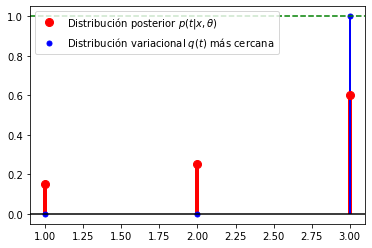

In [11]:
plt.plot([1, 2, 3], [0.15, 0.25, 0.6], 'ro', ms=8, label=r"Distribución posterior $p(t|x, \theta)$")
plt.plot([1, 2, 3], [0, 0, 1], 'bo', ms=5, label=r"Distribución variacional $q(t)$ más cercana")
plt.vlines([1, 2, 3], 0, [0.15, 0.25, 0.6], colors='r', lw=4)
plt.vlines([1, 2, 3], 0, [0, 0, 1], colors='b', lw=2)
plt.axhline(y=0, color='k')
plt.axhline(y=1, ls='--', color='g')
plt.legend()
plt.show()

Es decir, la distribución variacional pondrá toda la probabilidad en el valor que tenga la mayor probabilidad en la distribución posterior.

Matemáticamente:

$$
q^{j+1}(t_i) = \delta(t_i - c_i^{j+1}),
$$

donde

$$
c_i^{j+1} = \arg \max_c p(t_i=c | x_i, \theta^j).
$$

Por otra parte, recordemos que la distribución posterior:

\begin{align}
p(t_i=c | x_i, \theta^j) & = \frac{p(x_i | t_i=c, \theta) p(t_i=c | \theta)}{p(x_i | \theta)} \\
                         & = \frac{1}{Z} \exp\left(-\frac{1}{2}||x_i - \mu_c||^2\right) \pi_c \\
                         & = \frac{1}{kZ} \exp\left(-\frac{1}{2}||x_i - \mu_c||^2\right).
\end{align}

De modo que:

$$
c_i^{j+1} = \arg \max_c p(t_i=c | x_i, \theta^j) = \arg \min_c ||x_i - \mu_c||^2
$$

#### ¡Justo como en K-Means!

### M-step

Debemos actualizar los parámetros $\mu$ de modo que maximicen la verosimilitud conjunta (recordar que la matriz de covarianzas y los pesos están fijos):

$$
\max_{\mu} \sum_{i=1}^{N} \mathbb{E}_{q^{j+1}(t_i)} \left[\log p(x_i, t_i| \mu)\right].
$$

Reutilizando lo que habíamos encontrado para el modelo de mezclas Gaussianas en general:

$$
\mu_c^{j+1} = \frac{\sum_{i=1}^{N} q^{j+1}(t_i=c)x_i}{\sum_{i=1}^{N} q(t_i=c)},
$$

donde 

$$
q^{j+1}(t_i) = \delta(t_i - c_i^{j+1}).
$$

De esta manera:

$$
\mu_c^{j+1} = \frac{\sum_{i: c_i^{j+1}=c} x_i}{\sum_{i: c_i^{j+1}=c} 1},
$$

#### ¡Justo como en K-Means!

## 3. En resumen

K-Means es un caso particular del algoritmo de maximización de la esperanza para mezclas Gaussianas:

- $\Sigma_c = I$.
- $\pi_c = \frac{1}{k}$.
- Se consideran distribuciones variacionales tipo $\delta$.

## Anuncios parroquiales

### 1. Clase de reposición (repaso): Sábado 5 de Noviembre a las 9:00 am
### 2. Examen módulo 2: comienza el jueves (en clase)

<script>
  $(document).ready(function(){
    $('div.prompt').hide();
    $('div.back-to-top').hide();
    $('nav#menubar').hide();
    $('.breadcrumb').hide();
    $('.hidden-print').hide();
  });
</script>

<footer id="attribution" style="float:right; color:#808080; background:#fff;">
Created with Jupyter by Esteban Jiménez Rodríguez.
</footer>